In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from scipy import stats

# Block Level Data 

In [52]:
blocks = pd.read_csv("blocks50.csv")

In [54]:
blocks=blocks.drop('LOGRECNO',1)

In [55]:
blocks.head(2)

,our2,our3,our4,our5,our6,our7,our8,our9,our10,our11,...,our42075,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160
0,1102,389,26,9,34,0,27,0,19,7,...,0,81,0,38,4,21,0,0,18,0
1,1061,470,33,31,43,20,31,0,15,6,...,0,103,0,56,23,9,0,0,15,0


In [4]:
blocks.shape

(15463, 1966)

In [5]:
attr = pd.read_csv("attr_interconn.csv")

In [6]:
attr.head(2)

,Unnamed: 0,Q_name,puma_attr,block_attr,ourID
0,0,B01001_sex by age_Total:_total:,0002_1,0002_1,our2
1,1,B01001_sex by age_Male:_male:,0002_2,0002_2,our3


In [7]:
attr.shape

(42796, 5)

In [8]:
features = pd.read_csv("features_we_use.csv")

In [9]:
features.head(2)

,Unnamed: 0,Q_name,puma_attr,block_attr,ourID
0,0,B01001_sex by age_Total:_total:,0002_1,0002_1,our2
1,1,B01001_sex by age_Male:_male:,0002_2,0002_2,our3


In [10]:
features.shape

(1965, 5)

In [11]:
predict = pd.read_csv("predict.csv")

In [12]:
predict.head(2)

,st,0165_10,0165_11,0165_12,0165_13,0165_14,0165_15,0165_16,0165_17,0165_18,...,0165_23,0165_24,0165_25,0165_26,0165_27,0165_28,0165_29,0165_30,internetP,label
0,il_129,284747,192327,3587,43965,13861,30104,90127,35810,54317,...,3133,6751,18757,7717,11040,23425,11487,80933,67.543117,train
1,wi_57,231386,143848,1469,29031,11311,17720,80797,38049,42748,...,562,1340,12964,5787,7177,12422,15409,72129,62.167979,train


In [13]:
predict.shape

(5777, 24)

# Reading Puma Data

In [14]:
puma = pd.read_csv("puma50.csv")

In [15]:
puma.head(2)

,st,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,label
0,il_129,710667,351639,22906,23456,24982,14097,8870,5073,4804,...,85878,0,25100,29949,7047,74,2341,21367,768,train
1,wi_57,599168,288604,22838,22923,21190,12728,10750,7433,5315,...,39792,39,12252,8283,8970,0,1870,8378,363,train


In [16]:
puma['label'].value_counts()

train    3696
test     1156
valid     925
dtype: int64

In [17]:
pumadata=puma.copy()

# Percentages of internet Users

In [18]:
internetper = predict['0165_11']/(predict['0165_10'])

### Defining threshhold to divide data between 0 and 1 i.e. no internet connection or internet connection. percentage of internet users > median is 1 and less than median 0


In [19]:
pumadata['internet']= internetper.apply(lambda x: 1 if x>=internetper.median() else 0)

## Dropping"st" id

In [20]:
#pumadata['st'] = pd.get_dummies(data=pumadata, columns=['st'], sparse=True)

In [30]:
pumadata=pumadata.drop('st',1)

### Dividing Data in Test Train and validation based on predifined labels. 
### And dropping labels

In [32]:
train = pumadata.loc[pumadata['label'] == 'train']
train = train.drop(['label'], axis=1)
test = pumadata.loc[pumadata['label'] == 'test']
test = test.drop(['label'], axis=1)

In [33]:
valid= pumadata.loc[pumadata['label'] == 'valid']
valid = valid.drop(['label'], axis=1)

Seperating Labels from each of training, testing and validation data sets so we are only left with features and labels stored in different variables.  

Converting each of the string nan values to numpy int nan values and converting all the features to numpy array

In [34]:
label_train = np.ravel(train[['internet']].values)
pred_train = train.drop(['internet'], axis=1)
pred_train = np.int64(pred_train.fillna(np.nan))

In [64]:
results = test.copy()
label_test = np.ravel(test[['internet']].values)
pred_test = test.drop(['internet'], axis=1)
feature_names = list(pred_test.columns.values)
pred_test = np.int64(pred_test.fillna(np.nan))

In [36]:
results1 = valid.copy()
label_valid = np.ravel(valid[['internet']].values)
pred_valid = valid.drop(['internet'], axis=1)
feature_names = list(pred_valid.columns.values)
pred_valid = np.int64(pred_valid.fillna(np.nan))

In [44]:
pred_test.shape

(1156, 1965)

In [45]:
pred_valid.shape

(925, 1965)

In [37]:
import multiprocessing
jobs=multiprocessing.cpu_count()

In [38]:
jobs

64

## Building Random Forest Classifier and training is over training data set. 
## Calculating Area Under Curve (AUC) score and accuracy 

In [39]:
num_trees = 500
rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=jobs, min_samples_split=10, verbose=2, oob_score = True)
rf.fit(X=pred_train, y=label_train)

# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions
# get AUC score (produce probabilistic predictions)
print (roc_auc_score(label_test, rf_predictions))

# get accuracy (predict the class)
rf_predictions_class = rf.predict(pred_test)
print (accuracy_score(label_test, rf_predictions_class, normalize=True))

[Parallel(n_jobs=64)]: Done   1 out of 500 | elapsed:    0.3s remaining:  2.1min
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=64)]: Done   1 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=64)]: Done  33 out of  64 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  43 out of  84 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  44 out of  86 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  54 out of 106 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=64)]: Done   1 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  11 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  13 out of  23 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  14 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  19 out of  36 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  23 out of  43 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 139 out of 276 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 143 out of 284 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 144 out of 285 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 154 out of 305 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 178 out of 353 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 


0.943771626298


### Running same model on validation set calculate AUC score

### Finding Accuracy of the score

In [48]:
rf_predictions_class = rf.predict(pred_valid)
print (accuracy_score(label_valid, rf_predictions_class, normalize=True))

[Parallel(n_jobs=64)]: Done   1 out of  28 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=64)]: Done  18 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  59 out of 116 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.7s finished


0.935135135135


In [51]:
pred_block

array([[ 8303,  1102,   389, ...,     0,    18,     0],
       [ 8304,  1061,   470, ...,     0,    15,     0],
       [ 8305,  2828,  1344, ...,     0,     4,     0],
       ..., 
       [23763,   849,   390, ...,    10,    68,     0],
       [23764,  1212,   624, ...,    18,    31,    15],
       [23765,   728,   376, ...,     0,    40,     0]])

### Cleaning block level data in same way as train, test and valid data set above

In [57]:
results2 = blocks.copy()
feature_names = list(blocks.columns.values)
pred_block = np.int64(blocks.fillna(np.nan))

### Storing prediction probability in results 2

In [58]:
rf_predictions = rf.predict_proba(pred_block)[:, 1]
results2['preds'] = rf_predictions

[Parallel(n_jobs=64)]: Done   1 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    1.1s finished


# Using Random Forest Regressor

In [71]:
pumadata1=puma.copy()
pumadata1['internet']= predict['0165_11']/predict['0165_10']
pumadata1= pumadata1.drop('st',1) 

In [72]:
trainr = pumadata1.loc[pumadata1['label'] == 'train']
trainr = trainr.drop(['label'], axis=1)
testr = pumadata1.loc[pumadata1['label'] == 'test']
testr = testr.drop(['label'], axis=1)

In [73]:
validr= pumadata1.loc[pumadata1['label'] == 'valid']
validr = validr.drop(['label'], axis=1)

In [74]:
label_trainr = np.ravel(trainr[['internet']].values)
pred_trainr = trainr.drop(['internet'], axis=1)
pred_trainr = np.int64(pred_trainr.fillna(np.nan))

In [75]:
resultsValues = testr.copy()
label_testr = np.ravel(testr[['internet']].values)
pred_testr = testr.drop(['internet'], axis=1)
feature_namesr = list(pred_testr.columns.values)
pred_testr = np.int64(pred_testr.fillna(np.nan))

In [76]:
resultsValuesValid = validr.copy()
label_validr = np.ravel(validr[['internet']].values)
pred_validr = validr.drop(['internet'], axis=1)
feature_namesvr = list(pred_validr.columns.values)
pred_validr = np.int64(pred_validr.fillna(np.nan))

In [77]:
rfr = RandomForestRegressor(n_estimators=500, n_jobs=jobs, criterion='mse', min_samples_split=10, verbose=2, oob_score = True)
rfr.fit(X=pred_trainr, y=label_trainr)



[Parallel(n_jobs=64)]: Done   1 out of 500 | elapsed:   18.7s remaining: 155.6min
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:  2.8min finished


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500building tree 16 of 500building tree 17 of 500

building tree 18 of 500building tree 19 of 500building tree 20 of 500building tree 21 of 500building tree 22 of 500building tree 23 of 500building tree 24 of 500
building tree 25 of 500



building tree 26 of 500
building tree 27 of 500
building tree 28 of 500building tree 29 of 500

 building tree 31 of 500building tree 32 of 500building tree 34 of 500building tree 33 of 500
building tree 35 of 500

building tree 30 of 500building tree 36 of 500building tree 37 of 500





 

building tree 39 of 500
building tree 40 of 500building tree 41 of 500building tree 42 of 500building tree 43 of 500buil

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=64, oob_score=True, random_state=None,
           verbose=2, warm_start=False)

In [101]:
# get accuracy (predict the class)
rfr_predictions_class = rfr.predict(pred_testr)
rfr_score = rfr.score(X=pred_testr, y=label_testr)
rfr_scoreV = rfr.score(X=pred_validr, y=label_validr)
rfr_scoreTra = rfr.score(X=pred_trainr, y=label_trainr)
#print (accuracy_score(label_testr, np.round(rfr_predictions_class)))
print ("test set r score : ", rfr_score)
print ("validation set r score: ",rfr_scoreV  )
print ("training set r score: ", rfr_scoreTra  )

[Parallel(n_jobs=64)]: Done   1 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=64)]: Done   1 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  28 out of  54 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=64)]: Done   1 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=64)]: Done   1 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  74 out of 146 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  76 out of 150 | elapsed:    0

('test set r score : ', 0.92307581708489683)
('validation set r score: ', 0.90456568409008442)
('training set r score: ', 0.98067006624840225)


In [79]:
feature_importance= list(rfr.feature_importances_)
feature_list = []
for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i],feature_importance[i]))
k= (sorted(feature_list,reverse=True,key=lambda x:x[1]))

In [80]:
df= pd.DataFrame(k,columns=['ourID','ImportanceValue'])

In [81]:
attimp=df.merge(attr,on='ourID')

In [82]:
attimp.to_csv("important_AttributesRF.csv")

In [83]:
resultsValues['preds']=rfr.predict(pred_testr)
resultsValuesValid['preds']=rfr.predict(pred_validr)

[Parallel(n_jobs=64)]: Done   1 out of  52 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Done   1 out of 148 | elapsed:    0.0s remaining:    2.6s
[Parallel(n_jobs=64)]: Done 132 out of 262 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 176 out of 350 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished


In [84]:
##Head of predicted test set
resultsValues.head()

,our2,our3,our4,our5,our6,our7,our8,our9,our10,our11,...,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,internet,preds
4621,102165,51565,4658,3566,3083,1769,1821,775,615,2036,...,0,2939,3270,848,0,383,2766,31,0.694395,0.726658
4622,101763,51212,3158,3941,3091,2948,1408,611,224,1822,...,54,4210,2240,985,0,620,3949,74,0.548435,0.638401
4623,144007,75625,5435,5259,5319,2681,2077,1176,1321,4621,...,0,7677,2894,1235,0,126,8331,0,0.818265,0.849305
4624,99220,48773,3011,2953,3762,1759,1569,481,591,1542,...,0,3010,4636,745,0,465,4414,200,0.660278,0.658378
4625,110369,55156,3149,3625,2197,2767,1513,284,1345,2879,...,0,3348,2626,905,0,449,2224,126,0.758393,0.760102


In [85]:
## Head of predicted validation set
resultsValuesValid.head()

,our2,our3,our4,our5,our6,our7,our8,our9,our10,our11,...,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,internet,preds
3696,142577,70443,4276,6029,4276,3146,1117,1210,1253,2085,...,0,3051,3570,2529,0,514,3198,152,0.637713,0.651381
3697,114712,56329,5500,4145,4643,2057,2006,499,1059,4195,...,0,1811,858,931,0,458,2670,0,0.752615,0.739592
3698,104489,53074,4286,3672,2450,1920,1931,1659,944,3958,...,0,3584,3493,1070,0,279,5147,0,0.754562,0.741712
3699,140780,68822,3264,4021,5030,3291,4604,1481,1887,4571,...,0,3468,1942,1175,0,168,3849,173,0.622128,0.702395
3700,108222,51738,2849,3699,2808,2039,929,661,408,2035,...,0,3556,4114,883,0,523,3093,0,0.864155,0.866558


## Applying Model at Block Level

In [86]:
resultsblock = blocks.copy()
feature_names = list(resultsblock.columns.values)
pred_block = np.int64(resultsblock.fillna(np.nan))

In [87]:
resultsblock['pred_blck']=rfr.predict(pred_block)

[Parallel(n_jobs=64)]: Done   1 out of  79 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=64)]: Done 251 out of 500 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    1.0s finished


In [88]:
resultsblock.head()

,our2,our3,our4,our5,our6,our7,our8,our9,our10,our11,...,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,pred_blck
0,1102,389,26,9,34,0,27,0,19,7,...,81,0,38,4,21,0,0,18,0,0.688562
1,1061,470,33,31,43,20,31,0,15,6,...,103,0,56,23,9,0,0,15,0,0.646425
2,2828,1344,217,93,141,137,0,35,51,92,...,119,0,38,0,77,0,0,4,0,0.590158
3,764,341,31,0,21,14,0,21,14,0,...,44,0,29,0,0,0,0,15,0,0.642878
4,1365,751,81,56,168,36,81,0,0,78,...,157,0,92,36,14,0,0,15,0,0.546630


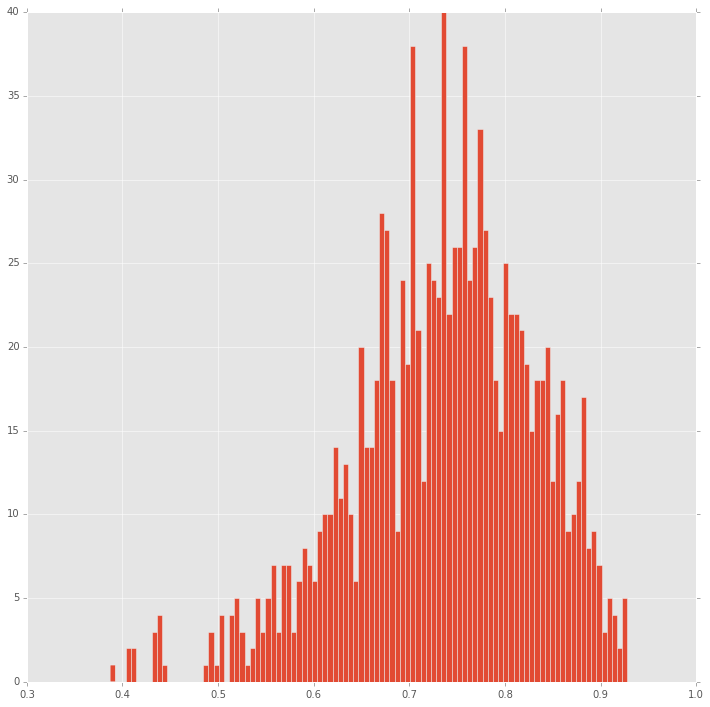

In [89]:
#plt.hist(resultsValues['preds'])
(resultsValues['preds']).hist(bins=100,figsize=(12,12))

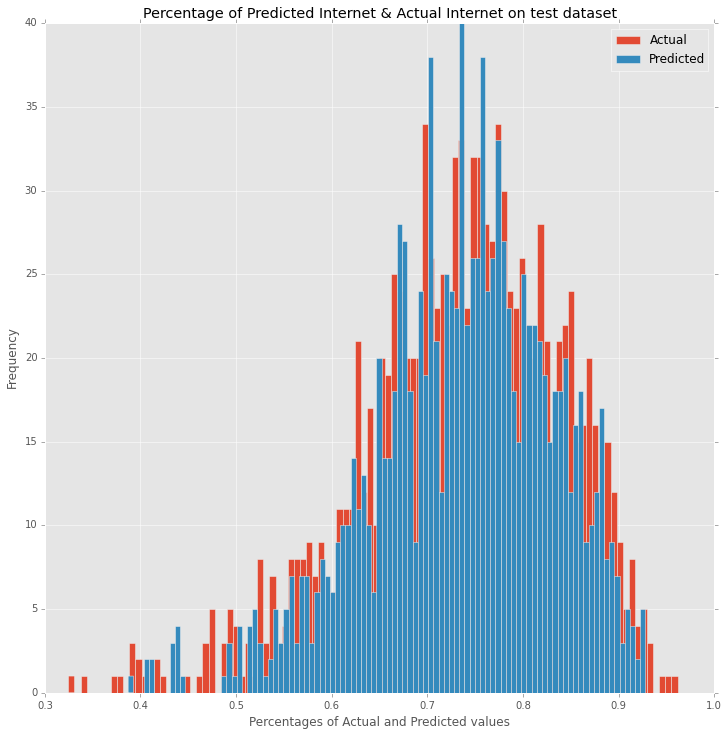

In [90]:
plt.figure(1)
plt.hist(label_testr,bins=100)
resultsValues['preds'].hist(bins=100,figsize=(12,12))
plt.title('Percentage of Predicted Internet & Actual Internet on test dataset')
plt.xlabel('Percentages of Actual and Predicted values')
plt.ylabel('Frequency')
plt.legend(['Actual','Predicted'])
plt.savefig('PredictHistogram.png')
plt.show()

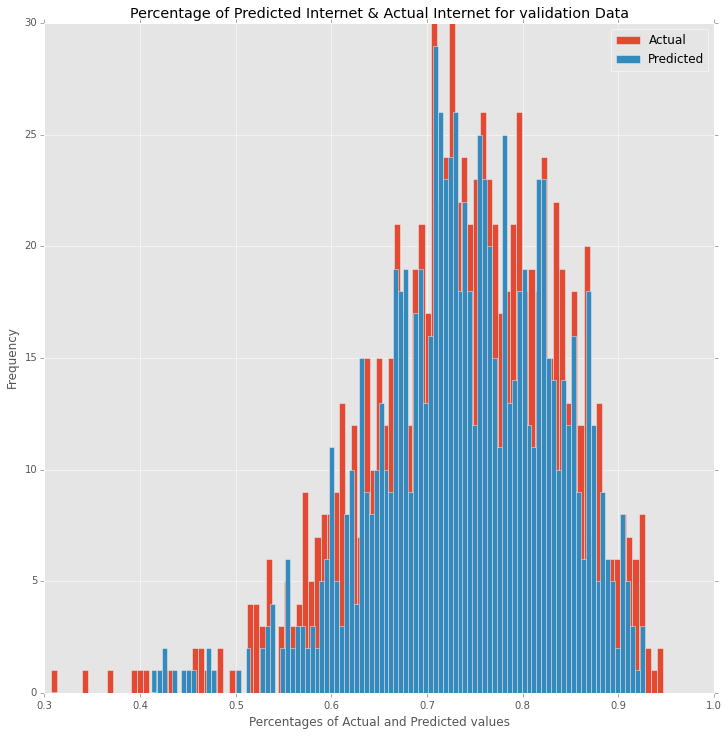

In [91]:
plt.figure(1)
plt.hist(label_validr,bins=100)
resultsValuesValid['preds'].hist(bins=100,figsize=(12,12))
plt.title('Percentage of Predicted Internet & Actual Internet for validation Data')
plt.legend(['Actual Validation','Predicted Validation'])
plt.xlabel('Percentages of Actual and Predicted values')
plt.ylabel('Frequency')
plt.legend(['Actual','Predicted'])
plt.savefig('PredictHistogramValid.png')
plt.show()

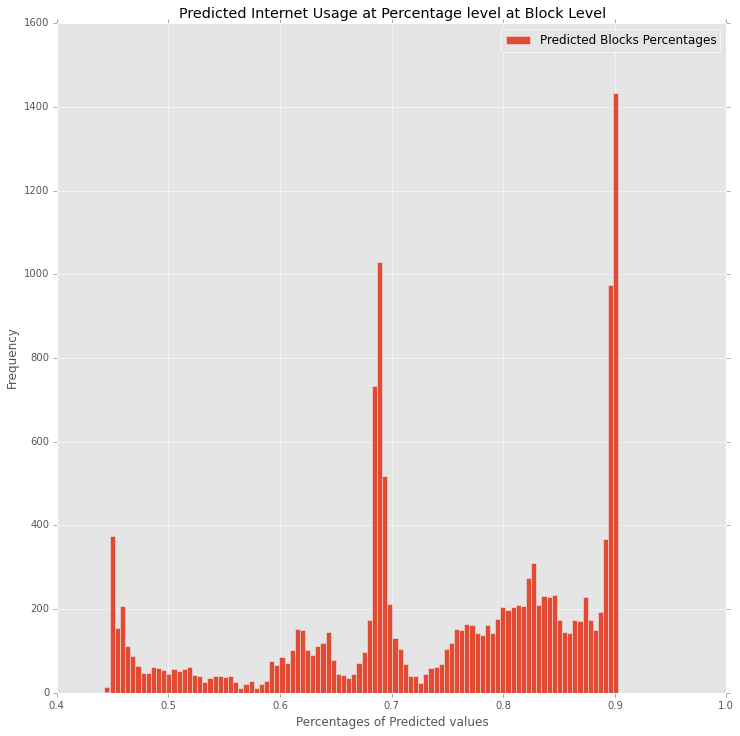

In [97]:
plt.figure(1)
resultsblock['pred_blck'].hist(bins=100,figsize=(12,12))
plt.title('Predicted Internet Usage at Percentage level at Block Level')
plt.xlabel('Percentages of Predicted values')
plt.ylabel('Frequency')
plt.legend(['Predicted Blocks Percentages'])
plt.savefig('PredictHistogramBlock.png')

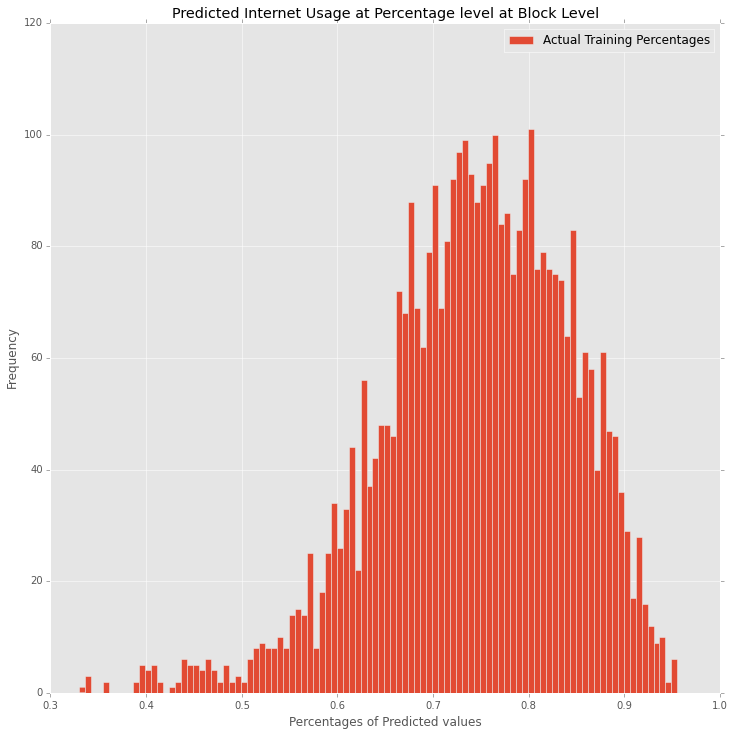

In [98]:
trainr[['internet']].hist(bins=100,figsize=(12,12))
plt.title('Predicted Internet Usage at Percentage level at Block Level')
plt.xlabel('Percentages of Predicted values')
plt.ylabel('Frequency')
plt.legend(['Actual Training Percentages'])
plt.savefig('ActualTraining.png')